In [1]:
from f1tenth_sim.run_scripts.run_functions import *
import pandas as pd 

from f1tenth_sim.data_tools.plotting_utils import *
from f1tenth_sim.utils.track_utils import CentreLine
import numpy as np
import os
if os.getcwd().split('/')[-1] == 'Notebooks':
    os.chdir('..')
    print(f'Changed directory to root of repo: {os.getcwd()}')


def ensure_path_exists(path):
    if not os.path.exists(path): 
        os.mkdir(path)

save_path = 'Data/LocalMapRacing/'
ensure_path_exists(save_path)


Changed directory to root of repo: /home/benjy/Documents/RacingRepos/f1tenth_sim


# High-performance Racing on Unmapped Tracks using Local Maps

This notebook provides the code required to regenerate the results for the article.

1. Local map extraction
    - Profile of local map lengths
    - Statistics tables
2. 


In [6]:
# test local map extraction
from f1tenth_sim.localmap_racing.LocalMapPP import LocalMapPP
test_id = "c1"
planner = LocalMapPP(test_id, True, False)
test_planning_all_maps(planner, test_id)

Testing on aut...
0 :: 796 LAP COMPLETE: Time: 31.84, Progress: 99.6
Testing on esp...
0 :: 1975 LAP COMPLETE: Time: 79.00, Progress: 99.6
Testing on gbr...
0 :: 1688 LAP COMPLETE: Time: 67.52, Progress: 99.5
Testing on mco...
0 :: 1484 LAP COMPLETE: Time: 59.36, Progress: 99.6


In [13]:

def load_boundary_data(planner_name, test_id, map_name="aut"):
    root = f"Logs/{planner_name}/"
    localmap_data_path = root + f"RawData_{test_id}/LocalMapData_{test_id}/"
    try:
        Logs = np.load(root + f"RawData_{test_id}/SimLog_{map_name}_0.npy")
    except:
        Logs, scans = None, None
    save_path = root + f"LocalMapGeneration_{test_id}/"
    ensure_path_exists(save_path)

    calculated_lengths = []
    projected_lengths = []
    for i in range(len(Logs)):

        boundaries = np.load(localmap_data_path + f"boundaries_{i}.npy")
        boundary_extension= np.load(localmap_data_path + f"boundExtension_{i}.npy") 

        calculated_line = (boundaries[:, :2] + boundaries[:, 2:]) /2
        calculated_el_lengths = np.linalg.norm(np.diff(calculated_line, axis=0), axis=1)
        calculated_lengths.append(np.sum(calculated_el_lengths, axis=0))
        if boundary_extension.shape[0] > 0:
            projected_line = (boundary_extension[:, :2] + boundary_extension[:, 2:]) /2
            projected_el_lengths = np.linalg.norm(np.diff(projected_line, axis=0), axis=1)
            projected_lengths.append(np.sum(projected_el_lengths, axis=0))
        else:
            projected_lengths.append(0)

    return np.array(calculated_lengths), np.array(projected_lengths), Logs[:, -1]


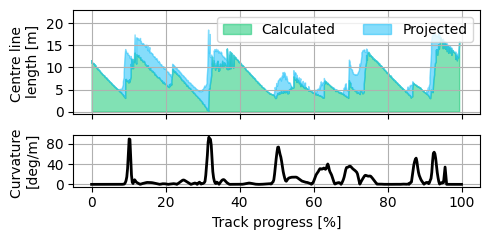

In [14]:
map_name = "aut"

calculated, projected, progresses = load_boundary_data("LocalMapPP", test_id, map_name)
progresses *= 100
centre = CentreLine(map_name)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 2.5), gridspec_kw={'height_ratios': [2, 1]})

ax1.fill_between(progresses, 0, calculated, color=sweedish_green, label="Calculated", alpha=0.5)
ax1.fill_between(progresses, calculated, calculated+projected, color=disco_ball, alpha=0.5, label="Projected")

s_norm = centre.s_path / centre.s_path[-1] * 100
curvature_deg = abs(np.rad2deg(centre.kappa))
ax2.plot(s_norm, curvature_deg, color='black', label="Curvature", linewidth=2)
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))

ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_ylim(-0.5, 23)
ax2.set_xlabel("Track progress [%]")
ax1.set_ylabel("Centre line \nlength [m]")
ax2.set_ylabel("Curvature \n[deg/m]")
ax1.legend(ncol=2)
plt.tight_layout()
ax1.grid()
ax2.grid()
plt.rcParams['pdf.use14corefonts'] = True

plt.savefig(f"{save_path}LengthProgress_{map_name}_{test_id}.svg", bbox_inches='tight', pad_inches=0.01)
plt.savefig(f"{save_path}LengthProgress_{map_name}_{test_id}.pdf", bbox_inches='tight', pad_inches=0.01)

In [84]:
map_list = ["aut", "esp", "gbr"]
root = f"Logs/LocalMapPP/"
test_id = "c1"
localmap_data_path = root + f"RawData_{test_id}/LocalMapData_{test_id}/"

data_dict = []
for map_name in map_list:
    Logs = np.load(root + f"RawData_{test_id}/SimLog_{map_name}_0.npy")
    for i in range(len(Logs)-1):
        local_track = np.load(localmap_data_path + f"local_map_{i}.npy")
        el_lengths = np.linalg.norm(np.diff(local_track[:, :2], axis=0), axis=1)
        data_dict.append({"Map": map_name, "length": np.sum(el_lengths)})

df = pd.DataFrame.from_records(data_dict)

descriptions = df.groupby("Map").describe(percentiles=[])
descriptions = descriptions["length"].reset_index()
descriptions = descriptions.drop(columns=["count", "50%"])

descriptions["Mean $\pm$  Std."] = descriptions["mean"].round(2).astype(str) + " $\pm$ " + descriptions["std"].round(2).astype(str)
descriptions["Min, Max"] = descriptions["min"].round(2).astype(str) + ", " + descriptions["max"].round(2).astype(str)
descriptions = descriptions.drop(columns=["mean", "std", "min", "max"])
descriptions = descriptions.set_index("Map").round(2).T
descriptions.columns = ["AUT", "ESP", "GBR"]

print(descriptions)
descriptions.to_latex(f"{save_path}LengthTable.tex", float_format="%.2f", na_rep="-")

                              AUT               ESP               GBR
Mean $\pm$  Std.  9.37 $\pm$ 3.81  10.68 $\pm$ 4.13  10.38 $\pm$ 4.04
Min, Max               3.7, 19.02        3.7, 24.61        3.7, 24.61


In [85]:
# Generate local map racing data for two stage planner
test_id = "mu60"
planner = LocalMapPP(test_id, True, True)
test_planning_all_maps(planner, test_id)

plot_trajectory_analysis(planner.name, test_id)

Testing on aut...
0 :: 473 LAP COMPLETE: Time: 18.92, Progress: 99.6
Testing on esp...
0 :: 1006 LAP COMPLETE: Time: 40.24, Progress: 99.7
Testing on gbr...
0 :: 885 LAP COMPLETE: Time: 35.40, Progress: 99.5
Testing on mco...
0 :: 846 LAP COMPLETE: Time: 33.84, Progress: 99.7
Vehicle name: LocalMapPP


In [3]:
# test local MPCC
from f1tenth_sim.localmap_racing.LocalMPCC import LocalMPCC
test_id = "mu60"
planner = LocalMPCC(test_id, True, surpress_output=True)
# test_planning_all_maps(planner, test_id)
test_planning_single_map(planner, "esp", test_id)

plot_trajectory_analysis(planner.name, test_id)

Testing on esp...
Solve failed: ReWarm Start: New outcome: False
S:0.616070 --> Action: [0.4    2.1434]
Solve failed: ReWarm Start: New outcome: False
S:1.003839 --> Action: [0.4    2.1434]
Solve failed: ReWarm Start: New outcome: False
S:4.793611 --> Action: [0.0303 8.    ]
Solve failed: ReWarm Start: New outcome: False
S:4.401849 --> Action: [0.0303 8.    ]
Solve failed: ReWarm Start: New outcome: False
S:3.997859 --> Action: [0.4    2.1434]
0 :: 1029 LAP COMPLETE: Time: 41.16, Progress: 99.6
Vehicle name: LocalMPCC


In [10]:
from f1tenth_sim.classic_racing.GlobalPurePursuit import GlobalPurePursuit

test_id = "mu70"
planner = GlobalPurePursuit(test_id, False, planner_name="FullStackPP")
test_full_stack_all_maps(planner, test_id)

plot_trajectory_analysis(planner.name, test_id)

Testing on aut...
0 :: 503 LAP COMPLETE: Time: 20.12, Progress: 99.6
Testing on esp...
0 :: 1036 LAP COMPLETE: Time: 41.44, Progress: 99.6
Testing on gbr...
0 :: 890 LAP COMPLETE: Time: 35.60, Progress: 99.6
Testing on mco...
0 :: 826 LAP COMPLETE: Time: 33.04, Progress: 99.6
Vehicle name: FullStackPP


In [4]:
from f1tenth_sim.classic_racing.GlobalMPCC3 import GlobalMPCC3

test_id = "mu60"
planner = GlobalMPCC3(test_id, False, planner_name="FullStackMPCC3", surpress_output=True)
test_planning_single_map(planner, "esp", test_id)
# test_full_stack_all_maps(planner, test_id)

plot_trajectory_analysis(planner.name, test_id)

Testing on esp...
0 :: 1152 LAP COMPLETE: Time: 46.08, Progress: 99.6
Vehicle name: FullStackMPCC3


## Plot the Racing Performance Results

In [5]:
from f1tenth_sim.data_tools.build_results_df import build_main_df
build_main_df()

summary_df = pd.read_csv("Logs/Summary.csv")


VehicleID  End-to-end SAC  End-to-end TD3  Follow the gap  Global MPCC  \
MapName                                                                  
AUT              1.126100        0.993648        0.992506     0.970274   
ESP              1.218860        0.967584        1.055730     0.975272   
GBR              1.173313        0.964935        1.033273     1.020517   

VehicleID  Global two-stage  Local MPCC  Local two-stage  
MapName                                                   
AUT                0.961964    0.976507         0.979001  
ESP                0.898874    0.958048         0.925632  
GBR                0.882719    0.994373         0.930871  


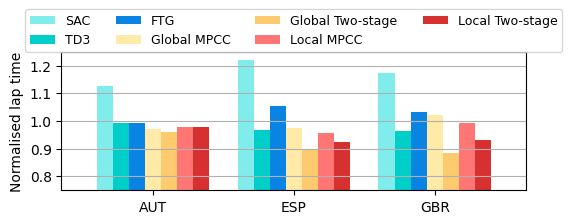

In [7]:

vehicle_id = {
            "EndToEnd_TestSAC": "End-to-end SAC", 
            "EndToEnd_TestTD3": "End-to-end TD3", 
            "FollowTheGap_Std": "Follow the gap", 
            "FullStackMPCC3_mu70": "Global MPCC", 
            "FullStackPP_mu70": "Global two-stage", 
            "LocalMPCC_mu60": "Local MPCC", 
            "LocalMapPP_mu60": "Local two-stage", 
            }


results_df = summary_df.loc[summary_df.VehicleID.isin(vehicle_id)]
results_df = results_df.replace({"VehicleID": vehicle_id})
results_df.insert(3, 'NormTime', results_df['AvgTime'] / results_df.groupby('MapName')['AvgTime'].transform('mean'))
results_df.insert(4, 'NormStd', results_df['StdTime'] / results_df.groupby('MapName')['AvgTime'].transform('mean'))

times_df = results_df.pivot(index="VehicleID", columns="MapName", values="NormTime")
times_df = times_df.drop(columns=["mco"])
times_df.columns = times_df.columns.str.upper()
print(times_df)
times_df = times_df.T

std_df = results_df.pivot(index="VehicleID", columns="MapName", values="NormStd")
std_df = std_df.drop(columns=["mco"])
std_df.columns = std_df.columns.str.upper()
std_df = std_df.T


color_list = ["#81ecec", "#00cec9", "#0984e3", "#ffeaa7", "#fdcb6e", "#ff7675", "#d63031"]

times_df.plot.bar(rot=0, figsize=(6, 1.8), legend=False, color=color_list, width=0.8)


plt.ylabel("Normalised lap time")
plt.xlabel("")
std = 0.25
plt.ylim(1-std, 1+std)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.grid(True, axis="y")

legend_names = ["SAC", "TD3", "FTG", "Global MPCC", "Global Two-stage", "Local MPCC", "Local Two-stage"]
plt.legend(legend_names, ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.35), fontsize=9)
plt.rcParams['pdf.use14corefonts'] = True

plt.savefig(f"{save_path}LaptimesBarPlot.svg", bbox_inches='tight', pad_inches=0)
plt.savefig(f"{save_path}LaptimesBarPlot.pdf", bbox_inches='tight', pad_inches=0)


In [8]:
summary_df = pd.read_csv("Logs/Summary.csv")

vehicle_id = {
            "EndToEnd_TestTD3": "End-to-end TD3", 
            "FollowTheGap_Std": "Follow the gap", 
            "FullStackPP_mu70": "Global two-stage", 
            "LocalMapPP_mu60": "Local two-stage", 
            }


results_df = summary_df.loc[summary_df.VehicleID.isin(vehicle_id)]
results_df = results_df.replace({"VehicleID": vehicle_id})

times_df = results_df.pivot(index="VehicleID", columns="MapName", values="AvgTime")
times_df = times_df.drop(columns=["mco"])
times_df.columns = times_df.columns.str.upper().T
times_df = times_df.round(2)

diffs = []
num_diffs = []
for i in range(len(times_df)):
    dif = {"MapName": f"{times_df.index[i]}"}
    ndif = {"MapName": f"{times_df.index[i]}"}
    for j in range(len(times_df.columns)): 
        if j == len(times_df.columns) - 1:
            dif[times_df.columns[j]] = f"{times_df.iloc[i, j]:.2f} "
            ndif[times_df.columns[j]] = 0
            continue
        num_diff = times_df.iloc[i, j] - times_df.iloc[i, -1]
        percent_diff = num_diff / times_df.iloc[i, -1] * 100
        dif[times_df.columns[j]] = f"{times_df.iloc[i, j]:.2f} ({percent_diff:.1f}\%)"
        ndif[times_df.columns[j]] = percent_diff
    diffs.append(dif)
    num_diffs.append(ndif)

diffs_df = pd.DataFrame(diffs)
diffs_df = diffs_df.set_index("MapName")
diffs_df = diffs_df.round(2)

num_diffs_df = pd.DataFrame(num_diffs)
num_diffs_df = num_diffs_df.set_index("MapName")
num_diffs_df = num_diffs_df.round(2)

means = num_diffs_df.mean(axis=0)
means = means.round(2)

diffs_df = pd.concat([diffs_df, means.to_frame().T])

print(diffs_df)

diffs_df.to_latex(f"{save_path}RelativeLaptimes.tex", float_format="%.2f")


MapName             AUT    ESP    GBR
VehicleID                            
End-to-end TD3    19.13  41.95  36.71
Follow the gap    19.11  45.77  39.31
Global two-stage  18.52  38.97  33.58
Local two-stage   18.85  40.13  35.42
                              AUT             ESP     GBR
End-to-end TD3    19.13 (-47.9\%)  41.95 (14.3\%)  36.71 
Follow the gap    19.11 (-51.4\%)  45.77 (16.4\%)  39.31 
Global two-stage  18.52 (-44.8\%)  38.97 (16.1\%)  33.58 
Local two-stage   18.85 (-46.8\%)  40.13 (13.3\%)  35.42 
0                          -47.73           15.01     0.0
